# Concepts in Spatial Linear Modelling

### Data Borrowing in Supervised Learning

In [1]:
import numpy as np
import libpysal.api as lp
import geopandas as gpd
import pandas as pd
import shapely.geometry as shp
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
listings = pd.read_csv('./data/berlin-listings.csv.gz')
listings['geometry'] = listings[['longitude','latitude']].apply(shp.Point, axis=1)
listings = gpd.GeoDataFrame(listings)
listings.crs = {'init':'epsg:4269'}
listings = listings.to_crs(epsg=3857)

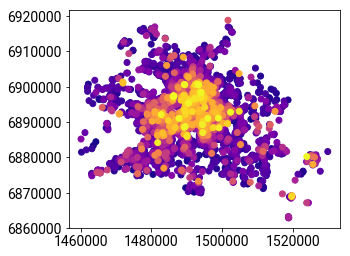

In [3]:
listings.sort_values('price').plot('price', cmap='plasma')

# Kernel Regressions

Kernel regressions are one exceptionally common way to allow observations to "borrow strength" from nearby observations. 

However, when working with spatial data, there are *two simultaneous senses of what is near:* 
- things that similar in attribute (classical kernel regression)
- things that are similar in spatial position (spatial kernel regression)

Below, we'll walk through how to use scikit to fit these two types of kernel regressions, show how it's not super simple to mix the two approaches together, and refer to an approach that does this correctly in another package. 

First, though, let's try to predict the log of an Airbnb's nightly price based on a few factors:
- accommodates: the number of people the airbnb can accommodate
- review_scores_rating: the aggregate rating of the listing
- bedrooms: the number of bedrooms the airbnb has
- bathrooms: the number of bathrooms the airbnb has
- beds: the number of beds the airbnb offers

In [4]:
model_data = listings[['accommodates', 'review_scores_rating', 
                       'bedrooms', 'bathrooms', 'beds', 
                       'price', 'geometry']].dropna()

In [5]:
Xnames = ['accommodates', 'review_scores_rating', 
               'bedrooms', 'bathrooms', 'beds' ]
X = model_data[Xnames].values
X = X.astype(float)
y = np.log(model_data[['price']].values)

Further, since each listing has a location, I'll extract the set of spatial coordinates coordinates for each listing.

In [6]:
coordinates = np.vstack(model_data.geometry.apply(lambda p: np.hstack(p.xy)).values)

scikit neighbor regressions are contained in the `sklearn.neighbors` module, and there are two main types:
- `KNeighborsRegressor`, which uses a k-nearest neighborhood of observations around each focal site
- `RadiusNeighborsRegressor`, which considers all observations within a fixed radius around each focal site.

Further, these methods can use inverse distance weighting to rank the relative importance of sites around each focal; in this way, near things are given more weight than far things, even when there's a lot of near things. 

In [7]:
import sklearn.neighbors as skn
import sklearn.metrics as skm

In [8]:
shuffle = np.random.permutation(len(y))
train,test = shuffle[:14000],shuffle[14000:]

So, let's fit three models:
- `spatial`: using inverse distance weighting on the nearest 500 neighbors geograpical space
- `attribute`: using inverse distance weighting on the nearest 500 neighbors in attribute space
- `both`: using inverse distance weighting in both geographical and attribute space. 

In [9]:
KNNR = skn.KNeighborsRegressor(weights='distance', n_neighbors=500)
spatial = KNNR.fit(coordinates[train,:],
                  y[train,:])
KNNR = skn.KNeighborsRegressor(weights='distance', n_neighbors=500)
attribute = KNNR.fit(X[train,:],
                    y[train,])
KNNR = skn.KNeighborsRegressor(weights='distance', n_neighbors=500)
both = KNNR.fit(np.hstack((coordinates,X))[train,:],
                y[train,:])

To score them, I'm going to grab their out of sample prediction accuracy and get their % explained variance:

In [10]:
sp_ypred =  spatial.predict(coordinates[test,:])
att_ypred = attribute.predict(X[test,:])
both_ypred = both.predict(np.hstack((X,coordinates))[test,:])

In [11]:
(skm.explained_variance_score(y[test,], sp_ypred),
 skm.explained_variance_score(y[test,], att_ypred),
 skm.explained_variance_score(y[test,], both_ypred))

(0.1267498912767503, 0.33869009948387185, -3.40302497292555e-09)

If you don't know $X$, using $Wy$ would be better than nothing, but it works nowhere near as well... less than half of the variance that is explained by nearness in feature/attribute space is explained by nearness in geographical space. 

Making things even worse, simply glomming on the geographical information to the feature set makes the model perform horribly. 

*There must be another way!*

One method that can exploit the fact that local data may be more informative in predicting $y$ at site $i$ than distant data is Geographically Weighted Regression, a type of Generalized Additive Spatial Model. Kind of like a Kernel Regression, GWR conducts a bunch of regressions at each training site only considering data near that site. This means it works like the kernel regressions above, but uses *both* the coordinates *and* the data in $X$ to predict $y$ at each site. It optimizes its sense of "local" depending on some information criteria or fit score.

You can find this in the `gwr` package, and significant development is ongoing on this at `https://github.com/pysal/gwr`.

# Data Borrowing

Another common case where these weights are used are in "feature engineering." Using the weights matrix, you can construct neighbourhood averages of the data matrix and use these as synthetic features in your model. These often have a strong relationship to the outcome as well, since spatial data is often smooth and attributes of nearby sites often have a spillover impact on each other. 

In [12]:
from libpysal.weights.util import fill_diagonal

First, we'll construct a Kernel weight from the data that we have, make it an adaptive Kernel bandwidth, and make sure that our kernel weights don't have any self-neighbors. Since we've got the data at each site anyway, we probably shouldn't use that data *again* when we construct our neighborhood-smoothed syntetic features.  

In [13]:
kW = lp.Kernel.from_dataframe(model_data, fixed=False, function='gaussian', k=100)
kW = fill_diagonal(kW, 0)

In [14]:
WX = lp.lag_spatial(kW, X)

I like `statsmodels` regression summary tables, so I'll pop it up here. 

In [15]:
import statsmodels.api as sm

/home/ljw/anaconda3/envs/gds/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [16]:
Xtable = pd.DataFrame(X, columns=Xnames)

Below are the results for the model with only the covariates used above:
- accommodates: the number of people the airbnb can accommodate
- review_scores_rating: the aggregate rating of the listing
- bedrooms: the number of bedrooms the airbnb has
- bathrooms: the number of bathrooms the airbnb has
- beds: the number of beds the airbnb offers

We've not used any of our synthetic features in `WX`. 

In [17]:
onlyX = sm.OLS(y,sm.add_constant(Xtable)).fit()
onlyX.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     1269.
Date:                Mon, 18 Jun 2018   Prob (F-statistic):               0.00
Time:                        08:00:33   Log-Likelihood:                -9260.8
No. Observations:               15516   AIC:                         1.853e+04
Df Residuals:                   15510   BIC:                         1.858e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.9682      0.044     67.590      0.000       2.882       3.054
accommodates             0.1882      0.004     44.362      0.000       0.180       0.197
review_scores_rating     0.0033      0.000      7.378      0.000       0.002       0.004
bedrooms                 0.1427      0.008     18.503      0.000       0.128       0.158
bathrooms                0.0062      0.012      0.497      0.619      -0.018       0.031
beds                    -0.0482      0.005     -9.221      0.000      -0.058      -0.038
==============================================================================
Omnibus:                      156.822   Durbin-Watson:                   1.716
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              265.898
Skew:                          -0.005   Prob(JB):                     1.82e-58
Kurtosis:                       3.641   Cond. No.                     1.17e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.17e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Then, we could fit a model using the neighbourhood average synthetic features as well:

In [18]:
WXtable = pd.DataFrame(WX, columns=['lag_{}'.format(name) for name in Xnames])

In [19]:
XWXtable = pd.concat((Xtable,WXtable),axis=1)

In [20]:
withWX = sm.OLS(y,sm.add_constant(XWXtable)).fit()
withWX.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     701.4
Date:                Mon, 18 Jun 2018   Prob (F-statistic):               0.00
Time:                        08:00:33   Log-Likelihood:                -9026.9
No. Observations:               15516   AIC:                         1.808e+04
Df Residuals:                   15505   BIC:                         1.816e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        2.7158      0.114     23.723      0.000       2.491       2.940
accommodates                 0.1829      0.004     43.616      0.000       0.175       0.191
review_scores_rating         0.0035      0.000      8.036      0.000       0.003       0.004
bedrooms                     0.1465      0.008     19.126      0.000       0.131       0.161
bathrooms                   -0.0135      0.012     -1.087      0.277      -0.038       0.011
beds                        -0.0448      0.005     -8.616      0.000      -0.055      -0.035
lag_accommodates             0.0162      0.001     16.632      0.000       0.014       0.018
lag_review_scores_rating    -0.0004   4.29e-05     -9.279      0.000      -0.000      -0.000
lag_bedrooms                 0.0001      0.002      0.086      0.931      -0.003       0.003
lag_bathrooms                0.0240      0.002     10.595      0.000       0.020       0.028
lag_beds                    -0.0150      0.001    -13.860      0.000      -0.017      -0.013
==============================================================================
Omnibus:                      163.213   Durbin-Watson:                   1.786
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              278.468
Skew:                          -0.023   Prob(JB):                     3.40e-61
Kurtosis:                       3.655   Cond. No.                     9.71e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.71e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This gains a nice bump in the model fit with no significant hit to model complexity. 

## Going Further

We could also use a spatial autoregressive model to further improve fit. This ceases to be estimatable in `statsmodels` and instead requires `pysal.spreg`, the spatial regression submodule of PySAL. Generalized method of moments estimators are available in `pysal.spreg.GM_Lag`, and maximum likelihood methods in `pysal.spreg.ML_Lag`. 

These methods are often harder to fit, though, so like `gwr`, they may be less performant on big data. But, you can usually achieve a gain in fit for no significant increase in the number of terms by using these models. 